[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/siowcm/cancer/blob/main/code/02-cancer.ipynb)

Note: Run notebook in colab

# Import libraries

In [1]:
# import libraries
import glob
import os
import re
import shutil

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from imutils import paths
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [2]:
# clone github repo
!git clone https://github.com/siowcm/cancer.git

Cloning into 'cancer'...
remote: Enumerating objects: 278383, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 278383 (delta 0), reused 11 (delta 0), pack-reused 278372
Receiving objects: 100% (278383/278383), 1.54 GiB | 14.24 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (555055/555055), done.


In [3]:
%cd ./cancer/code

/content/cancer/code


In [4]:
df = pd.read_csv("../data/cancer.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277524 entries, 0 to 277523
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   patient_id  277524 non-null  int64 
 1   label       277524 non-null  int64 
 2   path        277524 non-null  object
 3   file_name   277524 non-null  object
 4   img_x       277524 non-null  int64 
 5   img_y       277524 non-null  int64 
 6   height      277524 non-null  int64 
 7   width       277524 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 16.9+ MB


# Preprocessing
For preprocessing, the models parameters will be defined and also helper functions

In [6]:
# parameters
TRAIN_PATH = "../data/train"
VAL_PATH = "../data/val"
TEST_PATH = "../data/test"
IMG_SIZE = (100, 100)
BATCH_SIZE = 64
PATIENCE = 10
NUM_EPOCHS = 100
INIT_LR = 0.01

In [7]:
# create training, validation and testing data
df_train_and_val, df_test = train_test_split(
    df, train_size=0.8, random_state=42, stratify=df["label"]
)

df_train, df_val = train_test_split(
    df_train_and_val,
    train_size=0.8,
    random_state=42,
    stratify=df_train_and_val["label"],
)

In [8]:
# check the shape of training and testing data
print(f"Shape of training df: {df_train.shape}")
print(f"Shape of validation df: {df_val.shape}")
print(f"Shape of testing df: {df_test.shape}")

Shape of training df: (177615, 8)
Shape of validation df: (44404, 8)
Shape of testing df: (55505, 8)


In [9]:
# create folder/ subfolders if it does not exist
for folder in [TRAIN_PATH, VAL_PATH, TEST_PATH]:
    if not os.path.exists(folder):
        os.makedirs(folder)
    if not os.path.exists(os.path.join(folder, "0")):
        os.makedirs(os.path.join(folder, "0"))
    if not os.path.exists(os.path.join(folder, "1")):
        os.makedirs(os.path.join(folder, "1"))

In [10]:
# copy to newly created folders
for index, data in df_train.iterrows():
    shutil.copy2(data["path"], os.path.join(TRAIN_PATH, str(data["label"])))

for index, data in df_val.iterrows():
    shutil.copy2(data["path"], os.path.join(VAL_PATH, str(data["label"])))

for index, data in df_test.iterrows():
    shutil.copy2(data["path"], os.path.join(TEST_PATH, str(data["label"])))

In [11]:
# check folder structure
!apt-get install tree
!cd ../data ; tree --dirsfirst --filelimit 5

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 1s (74.5 kB/s)
Selecting previously unselected package tree.
(Reading database ... 155335 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
.
├── archive [280 entries exceeds filelimit, not opening dir]
├── test
│   ├── 0 [39748 entries exceeds filelimit, not opening dir]
│   └── 1 [15757 entries exceeds filelimit, not opening dir]
├── train
│   ├── 0 [127192 entries exceeds filelimit, not opening dir]
│   └── 1 [50

In [12]:
# create list pf images paths
train_paths = list(paths.list_images(TRAIN_PATH))
val_paths = list(paths.list_images(VAL_PATH))
test_paths = list(paths.list_images(TEST_PATH))

# print output for clarity
print(train_paths[:2])
print(val_paths[:2])
print(test_paths[:2])

['../data/train/0/13693_idx5_x2301_y2451_class0.png', '../data/train/0/10257_idx5_x1801_y701_class0.png']
['../data/val/0/9029_idx5_x1501_y51_class0.png', '../data/val/0/9077_idx5_x151_y1651_class0.png']
['../data/test/0/13021_idx5_x2101_y251_class0.png', '../data/test/0/9041_idx5_x2601_y1551_class0.png']


In [13]:
# create class weights
train_labels = [int(p.split(os.path.sep)[-2]) for p in train_paths]
train_labels = keras.utils.to_categorical(
    train_labels
)  # one-hot encode list into arrary
class_totals = train_labels.sum(axis=0)
class_weight = {}
for i in range(0, len(class_totals)):
    class_weight[i] = class_totals.max() / class_totals[i]
print(f"class weights: {class_weight}")

class weights: {0: 1.0, 1: 2.5224996}


In [14]:
# function to augment images
@tf.function                                        # decarator code to create Python-independent dataflow graphs out of your Python code.
def augmentation(image, label):                     # This will help you create performant and portable model.
    '''
    Takes in image tensor and label and
    return respective inputs after transformation
    '''
    image = tf.image.random_flip_left_right(image)  # random horizontal flips
    image = tf.image.random_flip_up_down(image)     # random horizontal flips
    return image, label                             # more augmenetation from tensorflow API https://www.tensorflow.org/api_docs/python/tf/image

In [15]:
def compile_fit_model(model, save_path):
    '''
    Takes in model object and string for saved path for training.
    Return model after training.
    '''
    model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=INIT_LR),
        metrics=[
            keras.metrics.BinaryAccuracy(),
            keras.metrics.AUC(),
            keras.metrics.Precision(),
            keras.metrics.Recall(),
        ],
    )

    callbacks_list = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=PATIENCE, restore_best_weights=True
        ),
        keras.callbacks.ModelCheckpoint(
            filepath=save_path, verbose=1, save_best_only=True
        ),
        keras.callbacks.ReduceLROnPlateau(verbose=1),
    ]

    history = model.fit(
        x=train_data,
        epochs=NUM_EPOCHS,
        callbacks=callbacks_list,
        validation_data=val_data,
        class_weight=class_weight,
        steps_per_epoch=len(train_data) // BATCH_SIZE,
        # validation_steps=len(val_data) // BATCH_SIZE,
    )

    return history, model

# Transfer Learning

In this section, the models will be built by using the convolution network of the pre-trained model (e.g. VGG16) as a backbone to extract features and add a fully-connected layer. 

## VGG16

In [16]:
# function to load image
def image_loader_vgg16(path):
    image = tf.io.read_file(path)                                   # read image file as binary
    image = tf.image.decode_png(image, channels=3)                  # decode into image tensor
    # image = tf.image.convert_image_dtype(image, dtype=tf.float32) # converts to float32 data type and scaling the values appropriately before casting.
    image = tf.cast(image, dtype=tf.float32)
    image = tf.image.resize(image, IMG_SIZE)                        # resize the image
    image = keras.applications.vgg16.preprocess_input(image)        # custom preprocessing for VGG16
    label = tf.strings.split(path, os.path.sep)[-2]                 # parse the class label from the file path
    label = tf.strings.to_number(label, tf.int32)
    return (image, label)

In [17]:
train_data = tf.data.Dataset.from_tensor_slices(train_paths)
train_data = (
    train_data.shuffle(len(train_paths))                            # shuffle data, optional as already did train_test_split in scikit-learn
    .map(image_loader_vgg16, num_parallel_calls=tf.data.AUTOTUNE)   # load the image
    .map(augmentation, num_parallel_calls=tf.data.AUTOTUNE)         # apply augmentation
    .cache()                                                        # caching for fast read
    .batch(batch_size=BATCH_SIZE)                                   # batching the data
    .prefetch(tf.data.AUTOTUNE)                                     # allows later elements to be prepared while the current element is being processed
)


val_data = tf.data.Dataset.from_tensor_slices(val_paths)                   # no augmentation & shuffle required for test data as it is ground truth
val_data = (
    val_data.map(image_loader_vgg16, num_parallel_calls=tf.data.AUTOTUNE)  # load the image
    .batch(batch_size=BATCH_SIZE)                                          # batching the data
    .prefetch(tf.data.AUTOTUNE)                                            # allows later elements to be prepared while the current element is being processed
)


test_data = tf.data.Dataset.from_tensor_slices(test_paths)                  # no augmentation & shuffle required for test data as it is ground truth
test_data = (
    test_data.map(image_loader_vgg16, num_parallel_calls=tf.data.AUTOTUNE)  # load the image
    .batch(batch_size=BATCH_SIZE)                                           # batching the data
    .prefetch(tf.data.AUTOTUNE)                                             # allows later elements to be prepared while the current element is being processed
)

In [18]:
#import pretrained and freeze the layers
VGG16 = keras.applications.VGG16(include_top=False, weights="imagenet")
VGG16.trainable = False

58900480/58889256 [==============================] - 3s 0us/step


In [19]:
#add custom binary prediction layer
model_vgg16 = keras.models.Sequential(
    [
        VGG16,
        # keras.layers.BatchNormalization(),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(units=1, activation="sigmoid"),
    ]
)

In [20]:
model_vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                        

In [21]:
#train model
history_vgg16, model_vgg16 = compile_fit_model(
    model=model_vgg16, save_path="vgg16.h5"
)

Epoch 1/100
43/43 [==============================] - ETA: 0s - loss: 2.3541 - binary_accuracy: 0.7089 - auc: 0.7080 - precision: 0.4885 - recall: 0.6021
Epoch 1: val_loss improved from inf to 0.42525, saving model to vgg16.h5
43/43 [==============================] - 37s 631ms/step - loss: 2.3541 - binary_accuracy: 0.7089 - auc: 0.7080 - precision: 0.4885 - recall: 0.6021 - val_loss: 0.4252 - val_binary_accuracy: 0.8317 - val_auc: 0.8612 - val_precision: 0.7272 - val_recall: 0.6518 - lr: 0.0100
Epoch 2/100
42/43 [============================>.] - ETA: 0s - loss: 0.6991 - binary_accuracy: 0.7987 - auc: 0.8511 - precision: 0.6330 - recall: 0.7626
Epoch 2: val_loss did not improve from 0.42525
43/43 [==============================] - 25s 598ms/step - loss: 0.6988 - binary_accuracy: 0.7976 - auc: 0.8512 - precision: 0.6299 - recall: 0.7654 - val_loss: 0.4763 - val_binary_accuracy: 0.8053 - val_auc: 0.8819 - val_precision: 0.6189 - val_recall: 0.8178 - lr: 0.0100
Epoch 3/100
43/43 [=========

In [71]:
#evaluate with test data
vgg16_eval = model_vgg16.evaluate(test_data)
vgg16_eval

868/868 [==============================] - 31s 35ms/step - loss: 0.8070 - binary_accuracy: 0.2916 - auc: 0.6235 - precision: 0.2860 - recall: 0.9995


[0.8069767951965332,
 0.29164940118789673,
 0.6235201358795166,
 0.28604382276535034,
 0.9994922876358032]

In [23]:
result_vgg16 = pd.DataFrame(history_vgg16.history)

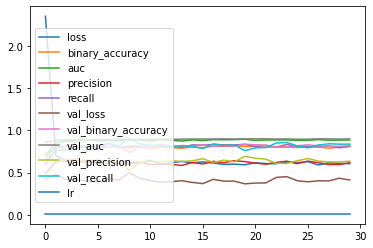

In [24]:
result_vgg16.plot()

## EfficientNetB0

In [31]:
# function to load image
def image_loader_effnetb0(path):
    image = tf.io.read_file(path)                                    # read image file as binary
    image = tf.image.decode_png(image, channels=3)                   # decode into image tensor
    # image = tf.image.convert_image_dtype(image, dtype=tf.float32)  # converts to float32 data type and scaling the values appropriately before casting.
    image = tf.image.resize(image, IMG_SIZE)                         # resize the image
    image = keras.applications.efficientnet.preprocess_input(image)  # custom preprocessing for efficientnet
    label = tf.strings.split(path, os.path.sep)[-2]                  # parse the class label from the file path
    label = tf.strings.to_number(label, tf.int32)
    return (image, label)

In [32]:
train_data = tf.data.Dataset.from_tensor_slices(train_paths)
train_data = (
    train_data.shuffle(len(train_paths))                              # shuffle data, optional as already did train_test_split in scikit-learn
    .map(image_loader_effnetb0, num_parallel_calls=tf.data.AUTOTUNE)  # load the image
    .map(augmentation, num_parallel_calls=tf.data.AUTOTUNE)           # apply augmentation
    .cache()                                                          # caching for fast read
    .batch(batch_size=BATCH_SIZE)                                     # batching the data
    .prefetch(tf.data.AUTOTUNE)                                       # allows later elements to be prepared while the current element is being processed
)


val_data = tf.data.Dataset.from_tensor_slices(val_paths)                      # no augmentation & shuffle required for test data as it is ground truth
val_data = (
    val_data.map(image_loader_effnetb0, num_parallel_calls=tf.data.AUTOTUNE)  # load the image
    .batch(batch_size=BATCH_SIZE)                                             # batching the data
    .prefetch(tf.data.AUTOTUNE)                                               # allows later elements to be prepared while the current element is being processed
)


test_data = tf.data.Dataset.from_tensor_slices(test_paths)                     # no augmentation & shuffle required for test data as it is ground truth
test_data = (
    test_data.map(image_loader_effnetb0, num_parallel_calls=tf.data.AUTOTUNE)  # load the image
    .batch(batch_size=BATCH_SIZE)                                              # batching the data
    .prefetch(tf.data.AUTOTUNE)                                                # allows later elements to be prepared while the current element is being processed  
)

In [33]:
#import pretrained and freeze the layers
effnetb0 = keras.applications.EfficientNetB0(include_top=False, weights="imagenet")
effnetb0.trainable = False

16719872/16705208 [==============================] - 0s 0us/step


In [34]:
model_effnetb0 = keras.models.Sequential(
    [
        effnetb0,
        # keras.layers.BatchNormalization(),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(units=1, activation="sigmoid"),
    ]
)

In [35]:
model_effnetb0.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                      

In [36]:
history_effnetb0, model_effnetb0 = compile_fit_model(
    model=model_effnetb0, save_path="effnetb0.h5"
)

Epoch 1/100
43/43 [==============================] - ETA: 0s - loss: 0.8136 - binary_accuracy: 0.7478 - auc_1: 0.8005 - precision_1: 0.5337 - recall_1: 0.7060
Epoch 1: val_loss improved from inf to 0.48694, saving model to effnetb0.h5
43/43 [==============================] - 25s 434ms/step - loss: 0.8136 - binary_accuracy: 0.7478 - auc_1: 0.8005 - precision_1: 0.5337 - recall_1: 0.7060 - val_loss: 0.4869 - val_binary_accuracy: 0.7844 - val_auc_1: 0.8642 - val_precision_1: 0.5879 - val_recall_1: 0.8041 - lr: 0.0100
Epoch 2/100
43/43 [==============================] - ETA: 0s - loss: 0.6687 - binary_accuracy: 0.7911 - auc_1: 0.8560 - precision_1: 0.5907 - recall_1: 0.7497
Epoch 2: val_loss improved from 0.48694 to 0.47187, saving model to effnetb0.h5
43/43 [==============================] - 17s 402ms/step - loss: 0.6687 - binary_accuracy: 0.7911 - auc_1: 0.8560 - precision_1: 0.5907 - recall_1: 0.7497 - val_loss: 0.4719 - val_binary_accuracy: 0.7827 - val_auc_1: 0.8754 - val_precision_1:

In [70]:
effnet_eval = model_effnetb0.evaluate(test_data)
effnet_eval

868/868 [==============================] - 24s 28ms/step - loss: 0.6959 - binary_accuracy: 0.2902 - auc_1: 0.5389 - precision_1: 0.2852 - recall_1: 0.9960


[0.695875346660614,
 0.2902261018753052,
 0.5388810038566589,
 0.2852054536342621,
 0.9960017800331116]

In [38]:
result_effnetb0 = pd.DataFrame(history_effnetb0.history)

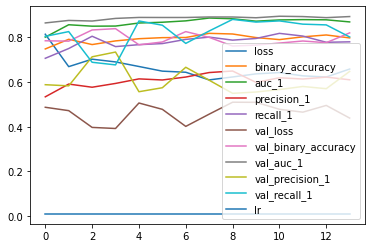

In [39]:
result_effnetb0.plot()

## Xception

In [40]:
# function to load image
def image_loader_xception(path):
    image = tf.io.read_file(path)                                   # read image file as binary
    image = tf.image.decode_png(image, channels=3)                  # decode into image tensor
    # image = tf.image.convert_image_dtype(image, dtype=tf.float32) # converts to float32 data type and scaling the values appropriately before casting.
    image = tf.cast(image, dtype=tf.float32)
    image = tf.image.resize(image, IMG_SIZE)                        # resize the image
    image = keras.applications.xception.preprocess_input(image)     # custom preprocessing for VGG16
    label = tf.strings.split(path, os.path.sep)[-2]                 # parse the class label from the file path
    label = tf.strings.to_number(label, tf.int32)
    return (image, label)


In [41]:
train_data = tf.data.Dataset.from_tensor_slices(train_paths)
train_data = (
    train_data.shuffle(len(train_paths))                            # shuffle data, optional as already did train_test_split in scikit-learn
    .map(image_loader_xception, num_parallel_calls=tf.data.AUTOTUNE)   # load the image
    .map(augmentation, num_parallel_calls=tf.data.AUTOTUNE)         # apply augmentation
    .cache()                                                        # caching for fast read
    .batch(batch_size=BATCH_SIZE)                                   # batching the data
    .prefetch(tf.data.AUTOTUNE)                                     # allows later elements to be prepared while the current element is being processed
)


val_data = tf.data.Dataset.from_tensor_slices(val_paths)                   # no augmentation & shuffle required for test data as it is ground truth
val_data = (
    val_data.map(image_loader_xception, num_parallel_calls=tf.data.AUTOTUNE)  # load the image
    .batch(batch_size=BATCH_SIZE)                                          # batching the data
    .prefetch(tf.data.AUTOTUNE)                                            # allows later elements to be prepared while the current element is being processed
)


test_data = tf.data.Dataset.from_tensor_slices(test_paths)                  # no augmentation & shuffle required for test data as it is ground truth
test_data = (
    test_data.map(image_loader_xception, num_parallel_calls=tf.data.AUTOTUNE)  # load the image
    .batch(batch_size=BATCH_SIZE)                                           # batching the data
    .prefetch(tf.data.AUTOTUNE)                                             # allows later elements to be prepared while the current element is being processed
)

In [42]:
xception = keras.applications.Xception(include_top=False, weights="imagenet")
xception.trainable = False

83697664/83683744 [==============================] - 1s 0us/step


In [43]:
model_xception = keras.models.Sequential(
    [
        xception,
        # keras.layers.BatchNormalization(),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(units=1, activation="sigmoid"),
    ]
)

In [44]:
model_xception.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                      

In [45]:
history_xception, model_xception = compile_fit_model(
    model=model_xception, save_path="xception.h5"
)

Epoch 1/100
43/43 [==============================] - ETA: 0s - loss: 1.1414 - binary_accuracy: 0.6781 - auc_2: 0.7294 - precision_2: 0.4720 - recall_2: 0.7124
Epoch 1: val_loss improved from inf to 0.46337, saving model to xception.h5
43/43 [==============================] - 27s 559ms/step - loss: 1.1414 - binary_accuracy: 0.6781 - auc_2: 0.7294 - precision_2: 0.4720 - recall_2: 0.7124 - val_loss: 0.4634 - val_binary_accuracy: 0.8037 - val_auc_2: 0.8414 - val_precision_2: 0.6399 - val_recall_2: 0.7056 - lr: 0.0100
Epoch 2/100
43/43 [==============================] - ETA: 0s - loss: 0.6839 - binary_accuracy: 0.7892 - auc_2: 0.8626 - precision_2: 0.6099 - recall_2: 0.7904
Epoch 2: val_loss improved from 0.46337 to 0.42154, saving model to xception.h5
43/43 [==============================] - 22s 534ms/step - loss: 0.6839 - binary_accuracy: 0.7892 - auc_2: 0.8626 - precision_2: 0.6099 - recall_2: 0.7904 - val_loss: 0.4215 - val_binary_accuracy: 0.8211 - val_auc_2: 0.8654 - val_precision_2:

In [69]:
xception_eval = model_xception.evaluate(test_data)
xception_eval

868/868 [==============================] - 27s 31ms/step - loss: 0.3798 - binary_accuracy: 0.8348 - auc_2: 0.8899 - precision_2: 0.7026 - recall_2: 0.7250


[0.3797591030597687,
 0.8348076939582825,
 0.8898898363113403,
 0.7025830149650574,
 0.7250111103057861]

In [47]:
result_xception = pd.DataFrame(history_xception.history)

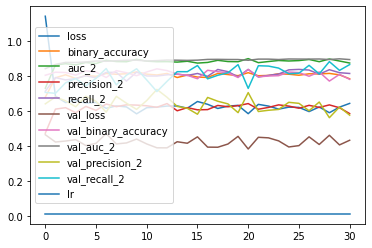

In [48]:
result_xception.plot()

## DenseNet121

In [49]:
# function to load image
def image_loader_densenet121(path):
    image = tf.io.read_file(path)                                   # read image file as binary
    image = tf.image.decode_png(image, channels=3)                  # decode into image tensor
    # image = tf.image.convert_image_dtype(image, dtype=tf.float32) # converts to float32 data type and scaling the values appropriately before casting.
    image = tf.cast(image, dtype=tf.float32)
    image = tf.image.resize(image, IMG_SIZE)                        # resize the image
    image = keras.applications.densenet.preprocess_input(image)        # custom preprocessing for VGG16
    label = tf.strings.split(path, os.path.sep)[-2]                 # parse the class label from the file path
    label = tf.strings.to_number(label, tf.int32)
    return (image, label)


In [50]:
train_data = tf.data.Dataset.from_tensor_slices(train_paths)
train_data = (
    train_data.shuffle(len(train_paths))                            # shuffle data, optional as already did train_test_split in scikit-learn
    .map(image_loader_densenet121, num_parallel_calls=tf.data.AUTOTUNE)   # load the image
    .map(augmentation, num_parallel_calls=tf.data.AUTOTUNE)         # apply augmentation
    .cache()                                                        # caching for fast read
    .batch(batch_size=BATCH_SIZE)                                   # batching the data
    .prefetch(tf.data.AUTOTUNE)                                     # allows later elements to be prepared while the current element is being processed
)


val_data = tf.data.Dataset.from_tensor_slices(val_paths)                   # no augmentation & shuffle required for test data as it is ground truth
val_data = (
    val_data.map(image_loader_densenet121, num_parallel_calls=tf.data.AUTOTUNE)  # load the image
    .batch(batch_size=BATCH_SIZE)                                          # batching the data
    .prefetch(tf.data.AUTOTUNE)                                            # allows later elements to be prepared while the current element is being processed
)


test_data = tf.data.Dataset.from_tensor_slices(test_paths)                  # no augmentation & shuffle required for test data as it is ground truth
test_data = (
    test_data.map(image_loader_densenet121, num_parallel_calls=tf.data.AUTOTUNE)  # load the image
    .batch(batch_size=BATCH_SIZE)                                           # batching the data
    .prefetch(tf.data.AUTOTUNE)                                             # allows later elements to be prepared while the current element is being processed
)

In [51]:
densenet121 = keras.applications.DenseNet121(include_top=False, weights="imagenet")
densenet121.trainable = False

29097984/29084464 [==============================] - 1s 0us/step


In [52]:
model_densenet121 = keras.models.Sequential(
    [
        densenet121,
        # keras.layers.BatchNormalization(),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(units=1, activation="sigmoid"),
    ]
)

In [53]:
model_densenet121.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_3 (Flatten)         (None, 1024)              0         
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               131200    
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                      

In [54]:
history_densenet121, model_densenet121 = compile_fit_model(
    model=model_densenet121, save_path="densenet152.h5"
)

Epoch 1/100
43/43 [==============================] - ETA: 0s - loss: 1.1845 - binary_accuracy: 0.7395 - auc_3: 0.7710 - precision_3: 0.5348 - recall_3: 0.7285
Epoch 1: val_loss improved from inf to 0.43731, saving model to densenet152.h5
43/43 [==============================] - 30s 575ms/step - loss: 1.1845 - binary_accuracy: 0.7395 - auc_3: 0.7710 - precision_3: 0.5348 - recall_3: 0.7285 - val_loss: 0.4373 - val_binary_accuracy: 0.8087 - val_auc_3: 0.8821 - val_precision_3: 0.6249 - val_recall_3: 0.8157 - lr: 0.0100
Epoch 2/100
43/43 [==============================] - ETA: 0s - loss: 0.6741 - binary_accuracy: 0.7925 - auc_3: 0.8641 - precision_3: 0.6204 - recall_3: 0.7995
Epoch 2: val_loss improved from 0.43731 to 0.40499, saving model to densenet152.h5
43/43 [==============================] - 22s 529ms/step - loss: 0.6741 - binary_accuracy: 0.7925 - auc_3: 0.8641 - precision_3: 0.6204 - recall_3: 0.7995 - val_loss: 0.4050 - val_binary_accuracy: 0.8167 - val_auc_3: 0.8924 - val_precis

In [68]:
densenet_eval = model_densenet121.evaluate(test_data)
densenet_eval

868/868 [==============================] - 32s 37ms/step - loss: 0.3963 - binary_accuracy: 0.8251 - auc_3: 0.9045 - precision_3: 0.6509 - recall_3: 0.8281


[0.396266371011734,
 0.825096845626831,
 0.9045379757881165,
 0.6508554220199585,
 0.8281399011611938]

In [56]:
result_densenet121 = pd.DataFrame(history_densenet121.history)

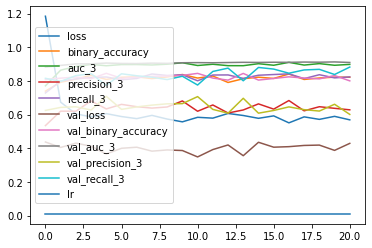

In [57]:
result_densenet121.plot()

## ResNet152V2 

In [58]:
# function to load image
def image_loader_resnet152(path):
    image = tf.io.read_file(path)                                   # read image file as binary
    image = tf.image.decode_png(image, channels=3)                  # decode into image tensor
    # image = tf.image.convert_image_dtype(image, dtype=tf.float32) # converts to float32 data type and scaling the values appropriately before casting.
    image = tf.cast(image, dtype=tf.float32)
    image = tf.image.resize(image, IMG_SIZE)                        # resize the image
    image = keras.applications.resnet_v2.preprocess_input(image)        # custom preprocessing for VGG16
    label = tf.strings.split(path, os.path.sep)[-2]                 # parse the class label from the file path
    label = tf.strings.to_number(label, tf.int32)
    return (image, label)


In [59]:
train_data = tf.data.Dataset.from_tensor_slices(train_paths)
train_data = (
    train_data.shuffle(len(train_paths))                            # shuffle data, optional as already did train_test_split in scikit-learn
    .map(image_loader_resnet152, num_parallel_calls=tf.data.AUTOTUNE)   # load the image
    .map(augmentation, num_parallel_calls=tf.data.AUTOTUNE)         # apply augmentation
    .cache()                                                        # caching for fast read
    .batch(batch_size=BATCH_SIZE)                                   # batching the data
    .prefetch(tf.data.AUTOTUNE)                                     # allows later elements to be prepared while the current element is being processed
)


val_data = tf.data.Dataset.from_tensor_slices(val_paths)                   # no augmentation & shuffle required for test data as it is ground truth
val_data = (
    val_data.map(image_loader_resnet152, num_parallel_calls=tf.data.AUTOTUNE)  # load the image
    .batch(batch_size=BATCH_SIZE)                                          # batching the data
    .prefetch(tf.data.AUTOTUNE)                                            # allows later elements to be prepared while the current element is being processed
)


test_data = tf.data.Dataset.from_tensor_slices(test_paths)                  # no augmentation & shuffle required for test data as it is ground truth
test_data = (
    test_data.map(image_loader_resnet152, num_parallel_calls=tf.data.AUTOTUNE)  # load the image
    .batch(batch_size=BATCH_SIZE)                                           # batching the data
    .prefetch(tf.data.AUTOTUNE)                                             # allows later elements to be prepared while the current element is being processed
)

In [60]:
resnet152 = keras.applications.ResNet152V2(include_top=False, weights="imagenet")
resnet152.trainable = False

234561536/234545216 [==============================] - 1s 0us/step


In [61]:
model_resnet152 = keras.models.Sequential(
    [
        resnet152,
        # keras.layers.BatchNormalization(),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(units=1, activation="sigmoid"),
    ]
)

In [62]:
model_resnet152.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, None, None, 2048)  58331648  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               262272    
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                      

In [63]:
history_resnet152, model_resnet152 = compile_fit_model(
    model=model_resnet152, save_path="resnet152.h5"
)

Epoch 1/100
43/43 [==============================] - ETA: 0s - loss: 1.2721 - binary_accuracy: 0.4462 - auc_4: 0.6735 - precision_4: 0.3157 - recall_4: 0.8190
Epoch 1: val_loss improved from inf to 0.65492, saving model to resnet152.h5
43/43 [==============================] - 68s 1s/step - loss: 1.2721 - binary_accuracy: 0.4462 - auc_4: 0.6735 - precision_4: 0.3157 - recall_4: 0.8190 - val_loss: 0.6549 - val_binary_accuracy: 0.7812 - val_auc_4: 0.7594 - val_precision_4: 0.6128 - val_recall_4: 0.6230 - lr: 0.0100
Epoch 2/100
43/43 [==============================] - ETA: 0s - loss: 0.8455 - binary_accuracy: 0.7816 - auc_4: 0.7605 - precision_4: 0.6051 - recall_4: 0.6465
Epoch 2: val_loss improved from 0.65492 to 0.59554, saving model to resnet152.h5
43/43 [==============================] - 56s 1s/step - loss: 0.8455 - binary_accuracy: 0.7816 - auc_4: 0.7605 - precision_4: 0.6051 - recall_4: 0.6465 - val_loss: 0.5955 - val_binary_accuracy: 0.8044 - val_auc_4: 0.7775 - val_precision_4: 0.6

In [67]:
resnet_eval = model_resnet152.evaluate(test_data)
resnet_eval

868/868 [==============================] - 71s 81ms/step - loss: 0.4139 - binary_accuracy: 0.8333 - auc_4: 0.8754 - precision_4: 0.7062 - recall_4: 0.7068


[0.4139392673969269,
 0.8332942724227905,
 0.8754485249519348,
 0.7062143087387085,
 0.7067970037460327]

In [65]:
result_resnet152 = pd.DataFrame(history_resnet152.history)

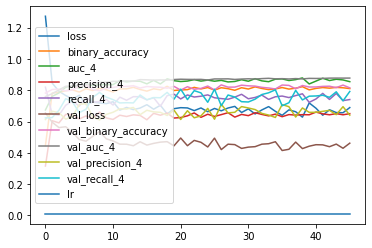

In [66]:
result_resnet152.plot()

# Evaluation

Among all the pretrained models, DenseNet performed the best on the unseen test data.

In [82]:
pd.DataFrame(
    data= [
           vgg16_eval[1:],
           effnet_eval[1:],
           xception_eval[1:],
           densenet_eval[1:],
           resnet_eval[1:]
     ],
     columns=[
              'accuracy',
              'auc_roc',
              'precision',
              'recall'
    ],
    index=[
           'VGG16',
           'EfficientNetB0',
           'Xception',
           'DenseNet',
           'ResNet'
    ]
)

,accuracy,auc_roc,precision,recall
VGG16,0.291649,0.623520,0.286044,0.999492
EfficientNetB0,0.290226,0.538881,0.285205,0.996002
Xception,0.834808,0.889890,0.702583,0.725011
DenseNet,0.825097,0.904538,0.650855,0.828140
ResNet,0.833294,0.875449,0.706214,0.706797


## Confusion matrix & ROC AUC

In [83]:
best_densenet = keras.models.load_model("densenet152.h5")

In [84]:
pred = best_densenet.predict(test_data)

In [85]:
y = np.concatenate([y for x, y in test_data], axis=0)

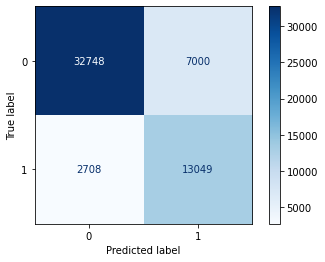

In [89]:
cm = confusion_matrix(y, np.round(pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues");

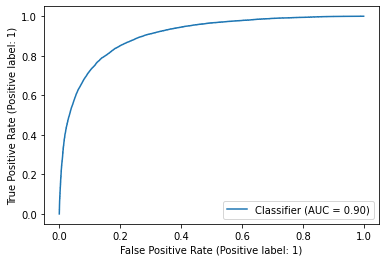

In [91]:
RocCurveDisplay.from_predictions(y, pred);

# Hyperparameters Tuning 

Using keras tuner API, hyperparameters for densnet will be further fine-tuned.

In [92]:
# function to load image
def image_loader_densenet121(path):
    image = tf.io.read_file(path)  # read image file as binary
    image = tf.image.decode_png(image, channels=3)  # decode into image tensor
    # image = tf.image.convert_image_dtype(image, dtype=tf.float32)# converts to float32 data type and scaling the values appropriately before casting.
    image = tf.image.resize(image, IMG_SIZE)  # resize the image
    image = keras.applications.densenet.preprocess_input(
        image
    )  # custom preprocessing for densenet121
    label = tf.strings.split(path, os.path.sep)[
        -2
    ]  # parse the class label from the file path
    label = tf.strings.to_number(label, tf.int32)
    return (image, label)

In [93]:
train_data = tf.data.Dataset.from_tensor_slices(train_paths)
train_data = (
    train_data.shuffle(
        len(train_paths)
    )  # shuffle data, optional as already did train_test_split in scikit-learn
    .map(
        image_loader_densenet121, num_parallel_calls=tf.data.AUTOTUNE
    )  # load the image
    .map(
        augmentation, num_parallel_calls=tf.data.AUTOTUNE
    )  # apply augmentation
    .cache()  # caching for fast read
    .batch(batch_size=BATCH_SIZE)  # batching the data
    .prefetch(
        tf.data.AUTOTUNE
    )  # allows later elements to be prepared while the current element is being processed
)


val_data = tf.data.Dataset.from_tensor_slices(
    val_paths
)  # no augmentation & shuffle required for test data as it is ground truth
val_data = (
    val_data.map(
        image_loader_densenet121, num_parallel_calls=tf.data.AUTOTUNE
    )  # load the image
    .batch(batch_size=BATCH_SIZE)  # batching the data
    .prefetch(
        tf.data.AUTOTUNE
    )  # allows later elements to be prepared while the current element is being processed
)


test_data = tf.data.Dataset.from_tensor_slices(
    test_paths
)  # no augmentation & shuffle required for test data as it is ground truth
test_data = (
    test_data.map(
        image_loader_densenet121, num_parallel_calls=tf.data.AUTOTUNE
    )  # load the image
    .batch(batch_size=BATCH_SIZE)  # batching the data
    .prefetch(
        tf.data.AUTOTUNE
    )  # allows later elements to be prepared while the current element is being processed
)

In [94]:
!pip install keras-tuner -q

     |████████████████████████████████| 133 kB 4.1 MB/s eta 0:00:01


In [95]:
densenet121 = keras.applications.DenseNet121(
    include_top=False, weights="imagenet"
)
densenet121.trainable = False

In [96]:
import keras_tuner as kt


def tune_model(hp):
    model_densenet121 = keras.models.Sequential(
        [
            densenet121,
            keras.layers.BatchNormalization(),
            keras.layers.GlobalAveragePooling2D(),
            keras.layers.Dropout(hp.Choice("dropout", [0.2, 0.3, 0.4, 0.5])),
            keras.layers.Flatten(),
            keras.layers.Dense(
                hp.Int("units", min_value=16, max_value=512, step=32),
                activation="relu",
            ),
            keras.layers.Dense(units=1, activation="sigmoid"),
        ]
    )

    model_densenet121.compile(
        loss="binary_crossentropy",
        optimizer=hp.Choice("optimizer", ["adam", "sgd", "nadam"]),
        metrics=[
            keras.metrics.BinaryAccuracy(),
            keras.metrics.AUC(),
            keras.metrics.Precision(),
            keras.metrics.Recall(),
        ],
    )
    return model_densenet121

In [97]:
tuner = kt.Hyperband(tune_model, objective="val_loss", max_epochs=5)

In [98]:
tuner.search(
    train_data,
    steps_per_epoch=len(train_data) // BATCH_SIZE,
    epochs=5,
    validation_data=val_data,
    validation_steps=len(val_data) // BATCH_SIZE,
)

Trial 10 Complete [00h 00m 20s]
val_loss: 0.08276955783367157

Best val_loss So Far: 0.07322724163532257
Total elapsed time: 00h 03m 03s
INFO:tensorflow:Oracle triggered exit


In [99]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
dropout: 0.2
units: 16
optimizer: adam
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.07322724163532257
Trial summary
Hyperparameters:
dropout: 0.3
units: 496
optimizer: adam
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.07468069344758987
Trial summary
Hyperparameters:
dropout: 0.5
units: 496
optimizer: nadam
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.07931743562221527
Trial summary
Hyperparameters:
dropout: 0.5
units: 464
optimizer: adam
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.08276955783367157
Trial summary
Hyperparameters:
dropout: 0.5
units: 496
optimizer: nadam
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0004
Score: 0.08376851677894592
Trial summary
Hyperparameters:
dropout: 0.3
units: 48
optimizer:

In [100]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model_tuned = tuner.hypermodel.build(best_hps)

In [101]:
history_densenet121_tuned, model_densenet121_tuned = compile_fit_model(
    model=model_tuned, save_path="densenet152_tuned.h5"
)

Epoch 1/100
43/43 [==============================] - ETA: 0s - loss: 0.7262 - binary_accuracy: 0.7762 - auc_2: 0.8525 - precision_2: 0.5787 - recall_2: 0.7842
Epoch 1: val_loss improved from inf to 0.44361, saving model to densenet152_tuned.h5
43/43 [==============================] - 36s 711ms/step - loss: 0.7262 - binary_accuracy: 0.7762 - auc_2: 0.8525 - precision_2: 0.5787 - recall_2: 0.7842 - val_loss: 0.4436 - val_binary_accuracy: 0.8266 - val_auc_2: 0.8655 - val_precision_2: 0.8348 - val_recall_2: 0.4854 - lr: 0.0100
Epoch 2/100
42/43 [============================>.] - ETA: 0s - loss: 0.6099 - binary_accuracy: 0.8166 - auc_2: 0.8880 - precision_2: 0.6331 - recall_2: 0.8086
Epoch 2: val_loss did not improve from 0.44361
43/43 [==============================] - 23s 536ms/step - loss: 0.6115 - binary_accuracy: 0.8165 - auc_2: 0.8882 - precision_2: 0.6348 - recall_2: 0.8104 - val_loss: 0.4581 - val_binary_accuracy: 0.8436 - val_auc_2: 0.8872 - val_precision_2: 0.7493 - val_recall_2: 

In [102]:
tuned_densenet = model_densenet121_tuned.evaluate(test_data)
tuned_densenet

868/868 [==============================] - 30s 34ms/step - loss: 0.3283 - binary_accuracy: 0.8576 - auc_2: 0.9181 - precision_2: 0.7297 - recall_2: 0.7915


[0.3283470869064331,
 0.8575984239578247,
 0.918131947517395,
 0.7297407984733582,
 0.7915212512016296]

# Conclusion

With the tuned hyperparameters, the final model performed slightly better from the original model. 

To conclude, using the pre-trained model with hyperparameters tuned, it was able to achieve 86% accuracy, 0.92 roc_auc, 73% precision and 79% recall.